# Stellar & Nebular Emission - BPASS+Cloudy

In these models, the nebular component is generated from Cloudy simulations on a large grid of metallicities and ionization parameters (see Nebular Emission Recipe).

The source models are BPASS v2.2.1, assuming a Chabrier et al. (2013) IMF. We include models of all ages in our Cloudy simulations, since old stellar populations in BPASS continue to produce an ionizing spectrum. The `nebula_old` option allows the user to turn off nebular emission from populations older than 30 Myr.

## Imports

In [13]:
import numpy as np
from scipy.interpolate import interp1d
from lightning.stellar import BPASSModelA24 as StellarModel
from lightning.stellar import BPASSBurstA24 as BurstModel
from lightning.sfh import PiecewiseConstSFH
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('lightning.plots.style.lightning-serif')
%matplotlib inline

## Initialize Model
Here we'll initialize our sort of 'default' stellar population model, which is integrated over stellar age bins to be used with a piecewise-constant SFH. We'll do it twice, with and without the nebular component, to compare.

We're passing the special keyword `nebula_old = False` to the first model to ensure that populations older than 30 Myr do not have nebular emission in their spectra. When you select these models when initializing Lightning, nebular emission from old populations is turned off by default. See Byler et al. (2017) for a brief discussion of the effect of post-AGB stars on the line ratios of a composite population. 

In [14]:
wave_grid = np.logspace(np.log10(0.01),
                        np.log10(10),
                        200)
filter_labels = ['SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z',
                 'MOIRCS_J', 'MOIRCS_H', 'MOIRCS_Ks',
                 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4']
redshift = 0.0
age = [0, 1e7, 1e8, 1e9, 5e9, 13.4e9]

stars_neb = StellarModel(filter_labels,
                         age=age,
                         redshift=redshift,
                         wave_grid=wave_grid,
                         nebula_old=False,
                         nebular_effects=True)

stars_noneb = StellarModel(filter_labels,
                           age=age,
                           redshift=redshift,
                           wave_grid=wave_grid,
                           nebular_effects=False)

burst = BurstModel(filter_labels, redshift=redshift, wave_grid=wave_grid)

## Simple Stellar Population Models
We've included the left-hand panel of this plot in basically every `Lightning`-related paper for years.

Text(0.5, 1.0, 'Without Nebula')

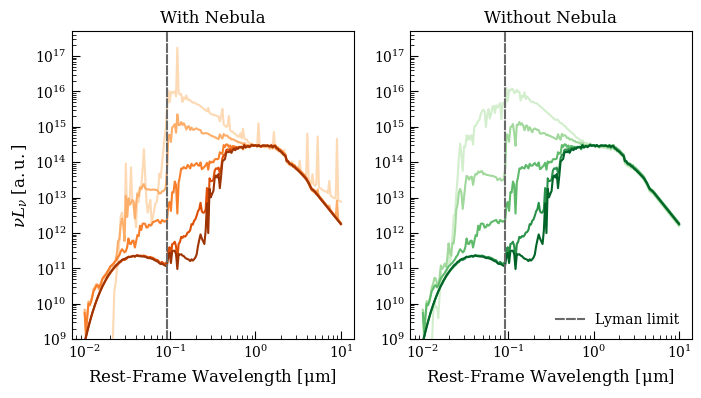

In [15]:
fig, axs = plt.subplots(1,2, figsize=(8,4))

Nmod = len(age) - 1

cm_neb = mpl.colormaps['Oranges']
colors_neb = cm_neb(np.linspace(0.2, 0.9, Nmod))

cm_noneb = mpl.colormaps['Greens']
colors_noneb = cm_noneb(np.linspace(0.2, 0.9, Nmod))

for i in np.arange(Nmod):

    finterp = interp1d(stars_neb.wave_grid_rest, stars_neb.Lnu_obs[i,-2,1,:])
    f1 = finterp(1)

    axs[0].plot(stars_neb.wave_grid_rest,
                stars_neb.nu_grid_obs * stars_neb.Lnu_obs[i,-2,1,:] / f1,
                color=colors_neb[i])

    finterp = interp1d(stars_noneb.wave_grid_rest, stars_noneb.Lnu_obs[i,-2,:])
    f1 = finterp(1)

    axs[1].plot(stars_noneb.wave_grid_rest,
                stars_noneb.nu_grid_obs * stars_noneb.Lnu_obs[i,-2,:] / f1,
                color=colors_noneb[i])

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(1e9, 5e17)
axs[0].axvline(0.0912, color='dimgray', linestyle='--')

axs[0].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs[0].set_ylabel(r'$\nu L_\nu\ [\rm a.u.]$')
axs[0].set_title('With Nebula')

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim(1e9, 5e17)
axs[1].axvline(0.0912, color='dimgray', linestyle='--', label='Lyman limit')
axs[1].legend(loc='lower right')

axs[1].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs[1].set_title('Without Nebula')

Where darker shades represent older ages. Note that nebular emission lines are only present for the two models with ages 100 Myr. The effect of free-free nebular continuum emission can be seen by comparing the lightest yellow curve on the left with the lightest green curve on the right. Note also that the Lyman continuum emission is not completely attenuated by the nebula (and old stellar populations with hot stripped stars produce low-level Lyman continuum emission). However, our dust models are opaque to the Lyman continuum by definition.

Note that the `BPASSBurstA24` model class provides a cleaner interface to the single-age population models, and can actually be used to fit SEDs. We'll use it now to look at the variation of the spectrum with $Z$ and $\log U$ for a 1 Myr old population:

Text(0.5, 0, 'Rest-Frame Wavelength [$\\rm \\mu m$]')

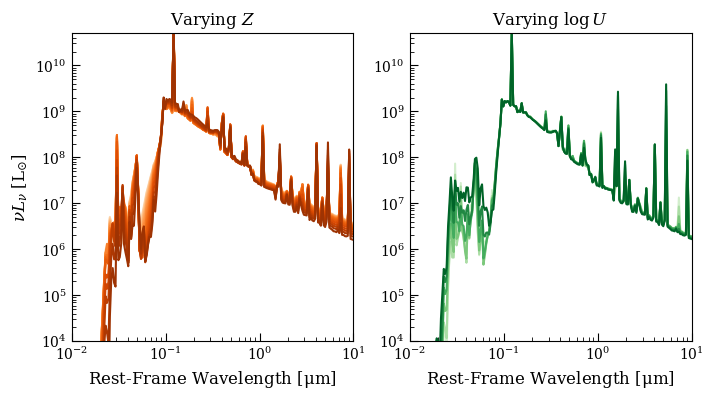

In [16]:
params_Z = np.tile([6.0, 6.0, 0, -2.0], (len(burst.Zmet), 1))
params_Z[:,2] = burst.Zmet

params_logU = np.tile([6.0, 6.0, 0.02, 0.0], (len(burst.logU), 1))
params_logU[:,3] = burst.logU

lnu_burst_Z,_,_ = burst.get_model_lnu_hires(params_Z)
lnu_burst_logU,_,_ = burst.get_model_lnu_hires(params_logU)

fig, axs = plt.subplots(1,2, figsize=(8,4))

Nmod = len(burst.Zmet) 
cm_neb = mpl.colormaps['Oranges']
colors_Z = cm_neb(np.linspace(0.2, 0.9, Nmod))

for i in range(Nmod):

    axs[0].plot(burst.wave_grid_obs,
                burst.nu_grid_obs * lnu_burst_Z[i,:],
                color=colors_Z[i])

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim(0.01, 10)
axs[0].set_ylim(1e4, 5e10)
axs[0].set_title(r'Varying $Z$')
axs[0].set_ylabel(r'$\nu L_\nu\ [\rm L_{\odot}]$')
axs[0].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')

Nmod = len(burst.logU) 
cm_noneb = mpl.colormaps['Greens']
colors_logU = cm_noneb(np.linspace(0.2, 0.9, Nmod))

for i in range(Nmod):

    axs[1].plot(burst.wave_grid_obs,
                burst.nu_grid_obs * lnu_burst_logU[i,:],
                color=colors_logU[i])

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlim(0.01, 10)
axs[1].set_ylim(1e4, 5e10)
axs[1].set_title(r'Varying $\log U$')
axs[1].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')


The models with lower metallicity (lighter colors) have more significant ionizing fluxes, while the models with larger ionization parameters have more luminous strong line emission and slightly larger ionizing escape from the nebula.

## Composite Stellar Population Models

To construct composite stellar populations we must of course assume a SFH for the population. Since we binned our simple stellar populations, we must use the `PiecewiseConstantSFH` model.

In [8]:
sfh = PiecewiseConstSFH(age)

Text(0.5, 1.0, 'Without Nebula')

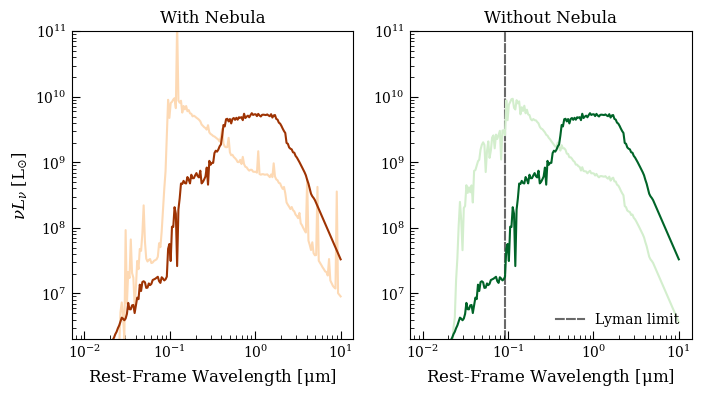

In [9]:
fig, axs = plt.subplots(1,2, figsize=(8,4))

coeffs= np.array([[1,1,0,0,0],
                  [0,0,1,1,1]])

Z = np.array([0.02, 0.02])
logU = np.array([-2.0, -2.0])

params = np.stack([Z, logU], axis=-1)

Nmod = coeffs.shape[0]

cm_neb = mpl.colormaps['Oranges']
colors_neb = cm_neb(np.linspace(0.2, 0.9, Nmod))

cm_noneb = mpl.colormaps['Greens']
colors_noneb = cm_noneb(np.linspace(0.2, 0.9, Nmod))

lnu_hires_neb,_,_ = stars_neb.get_model_lnu_hires(sfh, coeffs, params)
lnu_hires_noneb,_,_ = stars_noneb.get_model_lnu_hires(sfh, coeffs, Z)

for i in np.arange(Nmod):

    axs[0].plot(stars_neb.wave_grid_rest,
                stars_neb.nu_grid_obs * lnu_hires_neb[i,:],
                color=colors_neb[i])

    axs[1].plot(stars_noneb.wave_grid_rest,
                stars_noneb.nu_grid_obs * lnu_hires_noneb[i,:],
                color=colors_noneb[i])

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(2e6, 1e11)

axs[0].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs[0].set_ylabel(r'$\nu L_\nu\ [\rm L_{\odot}]$')
axs[0].set_title('With Nebula')

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim(2e6, 1e11)
axs[1].axvline(0.0912, color='dimgray', linestyle='--', label='Lyman limit', zorder=-1)
axs[1].legend(loc='lower right')

axs[1].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs[1].set_title('Without Nebula')


Here the lighter colored populations are star forming, and the darker ones are quiescent. Note that, as implied above, even if you were to use stellar populations without nebular extinction for your SED fitting in Lightning, the resulting galaxy would have no Lyman continuum leakage, as our ISM attenuation models are defined to be opaque to Lyman continuum radiation.